In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm

from datetime import datetime, timedelta

In [2]:
# Data provided by the course
PATH_ORDERS_BEFORE_DEC = "./Kurs/orders_before_dec.csv"
PATH_ORDERS_BEFORE_JAN = "./Kurs/orders_before_jan.csv"
PATH_SUBMISSION_DEC = "./Kurs/submission_dec.csv"
PATH_SUBMISSION_JAN = "./Kurs/submission_jan.csv"

PATH_TARGET_DEC = "./Kurs/gold_dec.csv"

# Data from online competition
PATH_ITEMS = "./Online/items.csv"

In [3]:
END_DATE = datetime(2020, 12, 31)
n_days = 183
START_DATE = END_DATE -timedelta(days = n_days-1)

In [4]:
train_data = pd.read_csv(PATH_ORDERS_BEFORE_JAN, sep="|")
target_data = pd.read_csv(PATH_SUBMISSION_JAN, sep="|")
items_features = pd.read_csv(PATH_ITEMS, sep="|")

In [5]:
train_data_merged = pd.merge(train_data, items_features, on="itemID")

0.1615366698274939

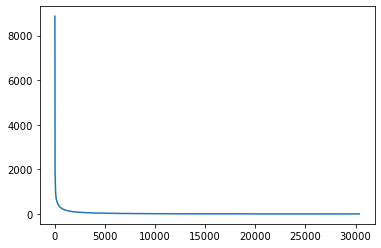

In [6]:
vals, cnts = np.unique(train_data_merged["itemID"].to_numpy(), return_counts=True)
cnts = sorted(cnts, reverse=True)
plt.plot(cnts)

n_samples = len(train_data_merged)

k = 100
np.sum(cnts[:k]) / n_samples

0.7859785115263483


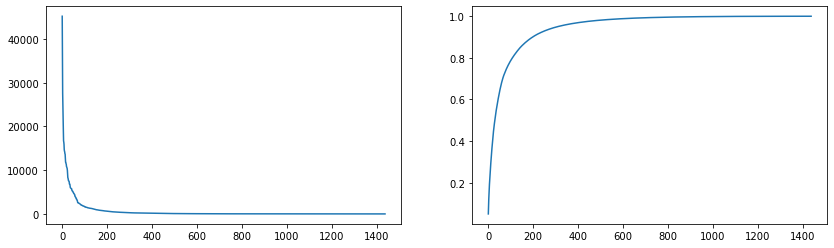

0.7958484613321176


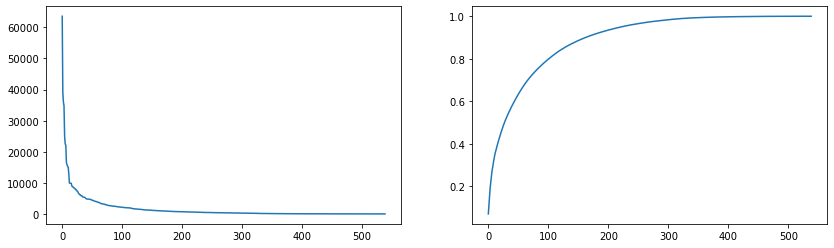

0.8638132381626284


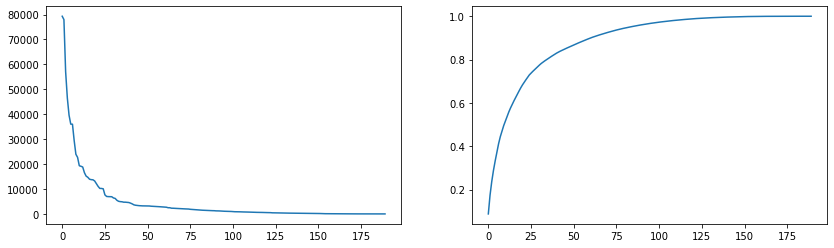

In [7]:
def plot_feature_frequency_and_importance(df, cnts, k):
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))
    cnts_sorted = sorted(cnts, reverse=True)
    axs[0].plot(cnts_sorted)

    n_samples = len(df)

    axs[1].plot(np.cumsum(cnts_sorted) / n_samples)
    print(np.sum(cnts_sorted[:k]) / n_samples)
    
    plt.show()

def one_hot_encode_top_features(df, feature, k):
    """
    This method one hot encodes the given feature but only keeps the k most frequent values.     
    """
    
    # Find the different values the feature can be and how often these values occur
    vals, cnts = np.unique(df[feature].to_numpy(), return_counts=True)
    
    plot_feature_frequency_and_importance(df, cnts, k)
    
    # Only keep the top k values that are used most often
    idxs = np.arange(len(cnts))
    idxs_sorted = [x for _, x in sorted(zip(cnts, idxs), reverse=True)]
    values_to_keep = vals[idxs_sorted][:k]
    
    # Replace all feature values that are not used frequently with -10
    feature_array = df[feature].to_numpy()
    feature_array[~np.isin(feature_array, values_to_keep)] = -10

    # One hot encode the feature and drop the entry with -10
    train_data_merged_ohe = pd.get_dummies(
        df, columns=[feature]
    )
    train_data_merged_ohe = train_data_merged_ohe.drop(columns=["{}_-10".format(feature)])
    
    return train_data_merged_ohe

def create_order_sequence(df):
    order_sequence = np.zeros(n_days)
    dates = df["date"].to_numpy()[-n_days:]
    orders = df["order"].to_numpy()[-n_days:]
    
    idx = 0
    for date, number_orders in zip(dates, orders):
        dt_date = datetime.strptime(date, '%Y-%m-%d')
        order_sequence[idx] = number_orders
        idx += 1
        
    return order_sequence
    
df_preprocessed = one_hot_encode_top_features(train_data_merged.copy(), "brand", 100)
df_preprocessed = pd.get_dummies(df_preprocessed, columns=["feature_1"])
df_preprocessed = pd.get_dummies(df_preprocessed, columns=["feature_2"])
df_preprocessed = one_hot_encode_top_features(df_preprocessed.copy(), "feature_3", 100)
df_preprocessed = pd.get_dummies(df_preprocessed, columns=["feature_4"])
df_preprocessed = one_hot_encode_top_features(df_preprocessed.copy(), "feature_5", 50)

In [8]:
df_preprocessed = df_preprocessed.drop(columns=["categories"])
df_preprocessed

,date,userID,itemID,order,brand_6,brand_18,brand_20,brand_73,brand_101,brand_127,...,feature_5_144,feature_5_146,feature_5_147,feature_5_151,feature_5_156,feature_5_159,feature_5_163,feature_5_175,feature_5_178,feature_5_190
0,2020-06-01,38769,3477,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-06-01,23570,3477,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-06-01,23495,3477,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-06-01,26073,3477,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-06-01,34302,3477,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905876,2020-12-31,39707,28203,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
905877,2020-12-31,16612,8146,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
905878,2020-12-31,12133,8614,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
905879,2020-12-31,25473,13818,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
userIDs = df_preprocessed["userID"].unique()

userIDs_target = target_data["userID"].unique()
itemIDs_target = target_data["itemID"].unique()

data = []

i = 0
for userID in tqdm(userIDs):
    if not userID in userIDs_target:
        continue
    user_data = df_preprocessed[df_preprocessed["userID"] == userID]
    itemIDs = user_data["itemID"].unique()
    
    for itemID in itemIDs:
        if not itemID in itemIDs_target:
            continue
            
        user_item_data = user_data[user_data["itemID"] == itemID]
        order_sequence = create_order_sequence(user_item_data)
        features = user_item_data.iloc[0][4:]
        
        np_user_item_data = np.hstack([userID, itemID, order_sequence, features])
        data.append(np_user_item_data)

100%|███████████████████████████████████████████████████████████████████████████| 46031/46031 [01:15<00:00, 611.11it/s]


In [10]:
order_sequence.shape

(183,)

In [11]:
data = np.array(data)
print(data.shape)

(108996, 457)


In [12]:
target_data

,userID,itemID,prediction
0,0,20664,NaN
1,0,28231,NaN
2,13,2690,NaN
3,15,1299,NaN
4,15,20968,NaN
...,...,...,...
9935,46118,20106,NaN
9936,46124,19677,NaN
9937,46125,12878,NaN
9938,46127,7963,NaN


In [13]:
# Only take the first two columns of "data", which contain userID and itemID
training_data = []

for index, (uid, iid) in tqdm(enumerate(data[:, :2])):
        
    res = target_data[(target_data["userID"] == uid) & (target_data["itemID"] == iid)]
    if len(res) == 0:
        continue
    else:
        training_data.append(data[index])

108996it [00:35, 3109.56it/s]


In [14]:
training_data = np.array(training_data)

In [15]:
training_data.shape

(9940, 457)

In [16]:
import torch
import torch.nn as nn

th_training_data = torch.Tensor(training_data[:, 2:].astype(np.int64))

In [22]:
FEATURE_SIZE_ORDER_SEQUENCE = 183
FEATURE_SIZE_BRAND = 100
FEATURE_SIZE_F_1 = 12
FEATURE_SIZE_F_2 = 4
FEATURE_SIZE_F_3 = 100
FEATURE_SIZE_F_4 = 6
FEATURE_SIZE_F_5 = 50

class MyModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.encoder_order_sequence = nn.Linear(FEATURE_SIZE_ORDER_SEQUENCE, 20)
        self.encoder_brand = nn.Linear(FEATURE_SIZE_BRAND, 20)
        self.encoder_f_3 = nn.Linear(FEATURE_SIZE_F_3, 20)
        self.encoder_f_5 = nn.Linear(FEATURE_SIZE_F_5, 20)
        
        self.ff1 = nn.Linear(
            4*20 + FEATURE_SIZE_F_1 + FEATURE_SIZE_F_2 + FEATURE_SIZE_F_4, 50
        )
        self.ff2 = nn.Linear(50, 50)
        self.ff3 = nn.Linear(50, 5)
        
        self.start_idxs = torch.cumsum(torch.Tensor([
            0, FEATURE_SIZE_ORDER_SEQUENCE, FEATURE_SIZE_BRAND, FEATURE_SIZE_F_1, FEATURE_SIZE_F_2,
            FEATURE_SIZE_F_3, FEATURE_SIZE_F_4
        ]), dim=0).int()
        self.end_idxs = torch.cumsum(torch.Tensor([
            FEATURE_SIZE_ORDER_SEQUENCE, FEATURE_SIZE_BRAND, FEATURE_SIZE_F_1, FEATURE_SIZE_F_2,
            FEATURE_SIZE_F_3, FEATURE_SIZE_F_4, FEATURE_SIZE_F_5
        ]), dim=0).int()
        
    def forward(self, x):
        inputs = []
        for start_idx, end_idx in zip(self.start_idxs, self.end_idxs):
            inputs.append(x[:, start_idx:end_idx])
        x = torch.hstack([
            self.encoder_order_sequence(inputs[0]), 
            self.encoder_brand(inputs[1]), 
            inputs[2], 
            inputs[3],
            self.encoder_f_3(inputs[4]), 
            inputs[5], 
            self.encoder_f_5(inputs[6]),  
        ])        
        
        x = nn.ReLU()(self.ff1(x))
        #x = nn.ReLU()(self.ff2(x))
        x = torch.tanh(self.ff2(x))
        x = nn.Softmax(dim=1)(self.ff3(x))
        
        return x

model = MyModel()
model.load_state_dict(torch.load("nn_model.th"))

<All keys matched successfully>

In [23]:
preds = []

for data_point in th_training_data:
    pred = model(data_point.reshape(1, -1))[0]
    preds.append(torch.argmax(pred))

In [35]:
preds = torch.Tensor(preds).type(torch.int64)
preds.shape

torch.Size([9940])

In [36]:
torch.unique(preds, return_counts=True)

(tensor([1, 2, 3, 4]), tensor([2015, 1279, 5296, 1350]))

In [37]:
target_data["prediction"] = preds

In [38]:
target_data

,userID,itemID,prediction
0,0,20664,4
1,0,28231,2
2,13,2690,2
3,15,1299,2
4,15,20968,4
...,...,...,...
9935,46118,20106,3
9936,46124,19677,3
9937,46125,12878,3
9938,46127,7963,2


In [39]:
target_data.to_csv("prediction_jan.csv", sep="|")